In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [8]:
!kaggle datasets download -d jangedoo/utkface-new

 96% 319M/331M [00:02<00:00, 143MB/s]
100% 331M/331M [00:02<00:00, 147MB/s]


In [9]:
import zipfile
zip = zipfile.ZipFile('/content/utkface-new.zip','r')
zip.extractall('/content')
zip.close()

In [10]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [12]:
folder_path = '/content/utkface_aligned_cropped/UTKFace'

In [13]:
age = []
gender = []
img_path = []
for file in os.listdir(folder_path) :
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [14]:
len(age)

23708

In [16]:
df = pd.DataFrame({'age' : age, 'gender':gender,'img' : img_path})

In [17]:
df.shape

(23708, 3)

In [18]:
df.head()

,age,gender,img
0,45,0,45_0_4_20170117202920775.jpg.chip.jpg
1,23,0,23_0_2_20170116221009406.jpg.chip.jpg
2,35,1,35_1_1_20170112215312112.jpg.chip.jpg
3,40,0,40_0_0_20170117152327651.jpg.chip.jpg
4,26,1,26_1_1_20170113182747229.jpg.chip.jpg


In [20]:
train_df = df.sample(frac = 1, random_state = 0).iloc[:20000]
test_df = df.sample(frac = 1, random_state = 0).iloc[20000:]

In [21]:
print(train_df.shape)
print(test_df.shape)

(20000, 3)
(3708, 3)


In [22]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [23]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory = folder_path,
                                                    x_col = 'img',
                                                    y_col = ['age','gender'],
                                                    target_size = (200,200),
                                                    class_mode = 'multi_output')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  directory = folder_path,
                                                  x_col = 'img',
                                                  y_col = ['age','gender'],
                                                  target_size = (200,200),
                                                  class_mode = 'multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [24]:
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model

In [25]:
vggnet = VGG16(include_top = False, input_shape = (200,200,3))

58889256/58889256 [==============================] - 0s 0us/step


In [26]:
vggnet.trainable = False

output = vggnet.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512, activation = 'relu')(flatten)
dense2 = Dense(512, activation = 'relu')(flatten)

dense3 = Dense(512, activation = 'relu' )(dense1)
dense4 = Dense(512, activation = 'relu')(dense2)

output1 = Dense(1, activation = 'linear', name = 'age')(dense3)
output2 = Dense(1, activation = 'sigmoid', name = 'gender')(dense4)

In [27]:
model = Model(inputs= vggnet.input, outputs = [output1,output2])

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 200, 200, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 200, 200, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

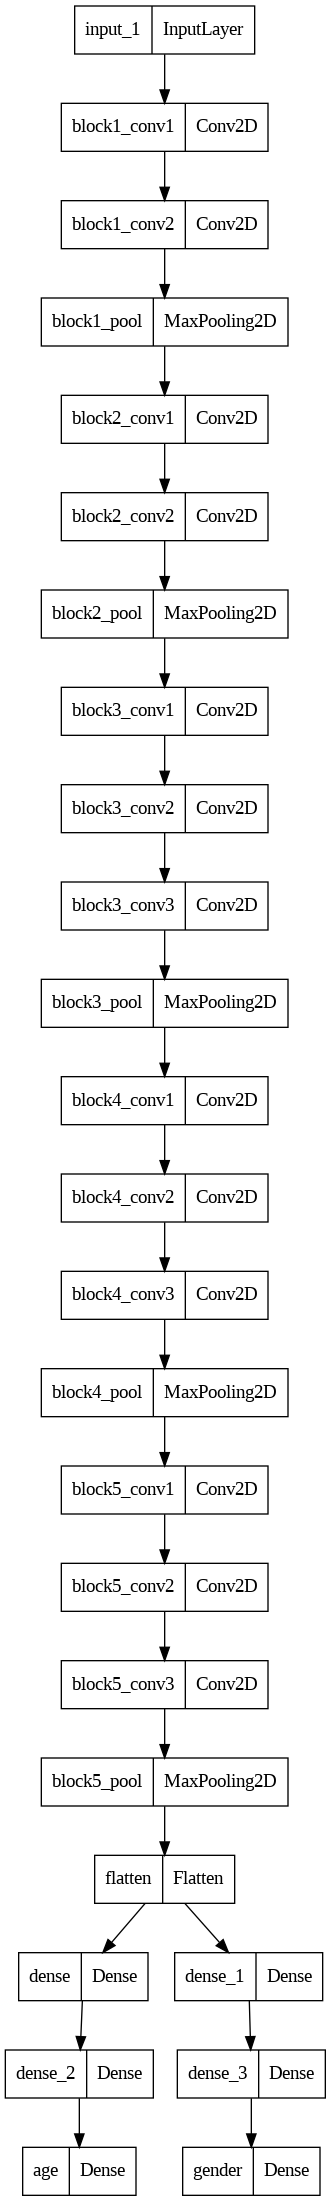

In [29]:
from keras.utils import plot_model
plot_model(model)